# Mapping Survival Probability to Channel Density

Loading BokehJS ...


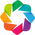

In [476]:
import numpy as np
import pandas as pd
import mscl_utils as mscl
import bokeh.io
import bokeh.plotting
import holoviews as hv 
import theano.tensor as tt
from tqdm import tqdm_notebook, tqdm
import bebi103
import pymc3 as pm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
mscl.set_plotting_style()
bokeh.io.output_notebook()
sns.set_palette('deep', color_codes=True)
hv.extension('bokeh')

In [334]:
import imp
imp.reload(mscl)

<module 'mscl_utils' from '/Users/gchure/lab/PhillipsLab201401-XXX/lab_code/mscl_analysis/mscl_utils.py'>

In [76]:
%opts Curve [width=600, height=400, bgcolor='whitesmoke', show_grid=True]
%opts BoxWhisker [width=600, height=400, bgcolor='whitesmoke', show_grid=True]
%opts Scatter [width=600, height=400, bgcolor='whitesmoke', show_grid=True]

In [77]:
# Load the two datasets
cal_data = pd.read_csv('../data/csv/compiled_calibration_data.csv')
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Make one dataframe containing the same axes.
cal_keys = cal_data.keys()
shock_keys = shock_data.keys()
for key in shock_keys:
    if key not in cal_keys:
        shock_data.drop(key, axis=1, inplace=True)

# Make a single dataframe
cal_data.insert(0, 'data_set', 'calibration')
shock_data.insert(0, 'data_set', 'shock')
data = pd.concat([cal_data, shock_data], ignore_index=True)

# Adjust the rescaled intensity to account for exposure. 
frac_exp = data['exposure_ms'].max() / data['exposure_ms']
data['rescaled_intensity'] = (data['intensity'] - data['mean_bg']) * frac_exp


In [4]:
bw = hv.BoxWhisker(data, kdims=['rbs', 'date'], vdims=['rescaled_intensity'])
bw

:BoxWhisker   [rbs,date]   (rescaled_intensity)

In [5]:
bw = hv.BoxWhisker(shock_data, kdims=['rbs'], vdims=['rescaled_intensity'])
bw

:BoxWhisker   [rbs]   (rescaled_intensity)

In [6]:
%%opts BoxWhisker [width=600]
# boxwhisker = hv.BoxWhisker(data[(data.rbs=='10sd1') | (data.rbs == 'sd0') | (data.rbs == 'sd1')], vdims=['rescaled_intensity'], kdims=['rbs', 'date'])
boxwhisker = hv.BoxWhisker(shock_data[shock_data.rbs=='sd1'], vdims=['rescaled_intensity'], kdims=['rbs', 'date'])
boxwhisker

:BoxWhisker   [rbs,date]   (rescaled_intensity)

## Analyzing the shock data 

In [78]:
# Look at the intensity distribution for survivors vs goners. 
shock_data = pd.read_csv('../data/csv/compiled_shock_data.csv')

# Prune it by excluding negative values and removing 10sd1.
shock_data = shock_data[(shock_data['rbs'] != '10sd1')  & (shock_data['rescaled_intensity'] > 0)]

In [79]:
# Convert based off of our standard candle. 
CHANNEL_NUM = 340
CHANNEL_ERR = 68
PERC_ERR = CHANNEL_ERR / CHANNEL_NUM

# Compute the reference values from the merged data. 
data = data[data['rescaled_intensity'] > 0]

# Candle strain is MLG910
candle_strain = data[data['rbs']=='mlg910']
candle_int = candle_strain['area'] * candle_strain['rescaled_intensity']
au_per_channel = np.mean(candle_int / CHANNEL_NUM)
au_per_channel_err = PERC_ERR * au_per_channel
print('The standard candle is {0} ± {1} a.u. per channel'.format(int(au_per_channel), int(au_per_channel_err)))

The standard candle is 4258 ± 851 a.u. per channel


In [80]:
# Include now channel density and error. 
shock_data['channel_density'] = (shock_data['rescaled_intensity'] / au_per_channel).astype(int)
shock_data['density_err'] = (shock_data['channel_density'] * PERC_ERR).astype(int)

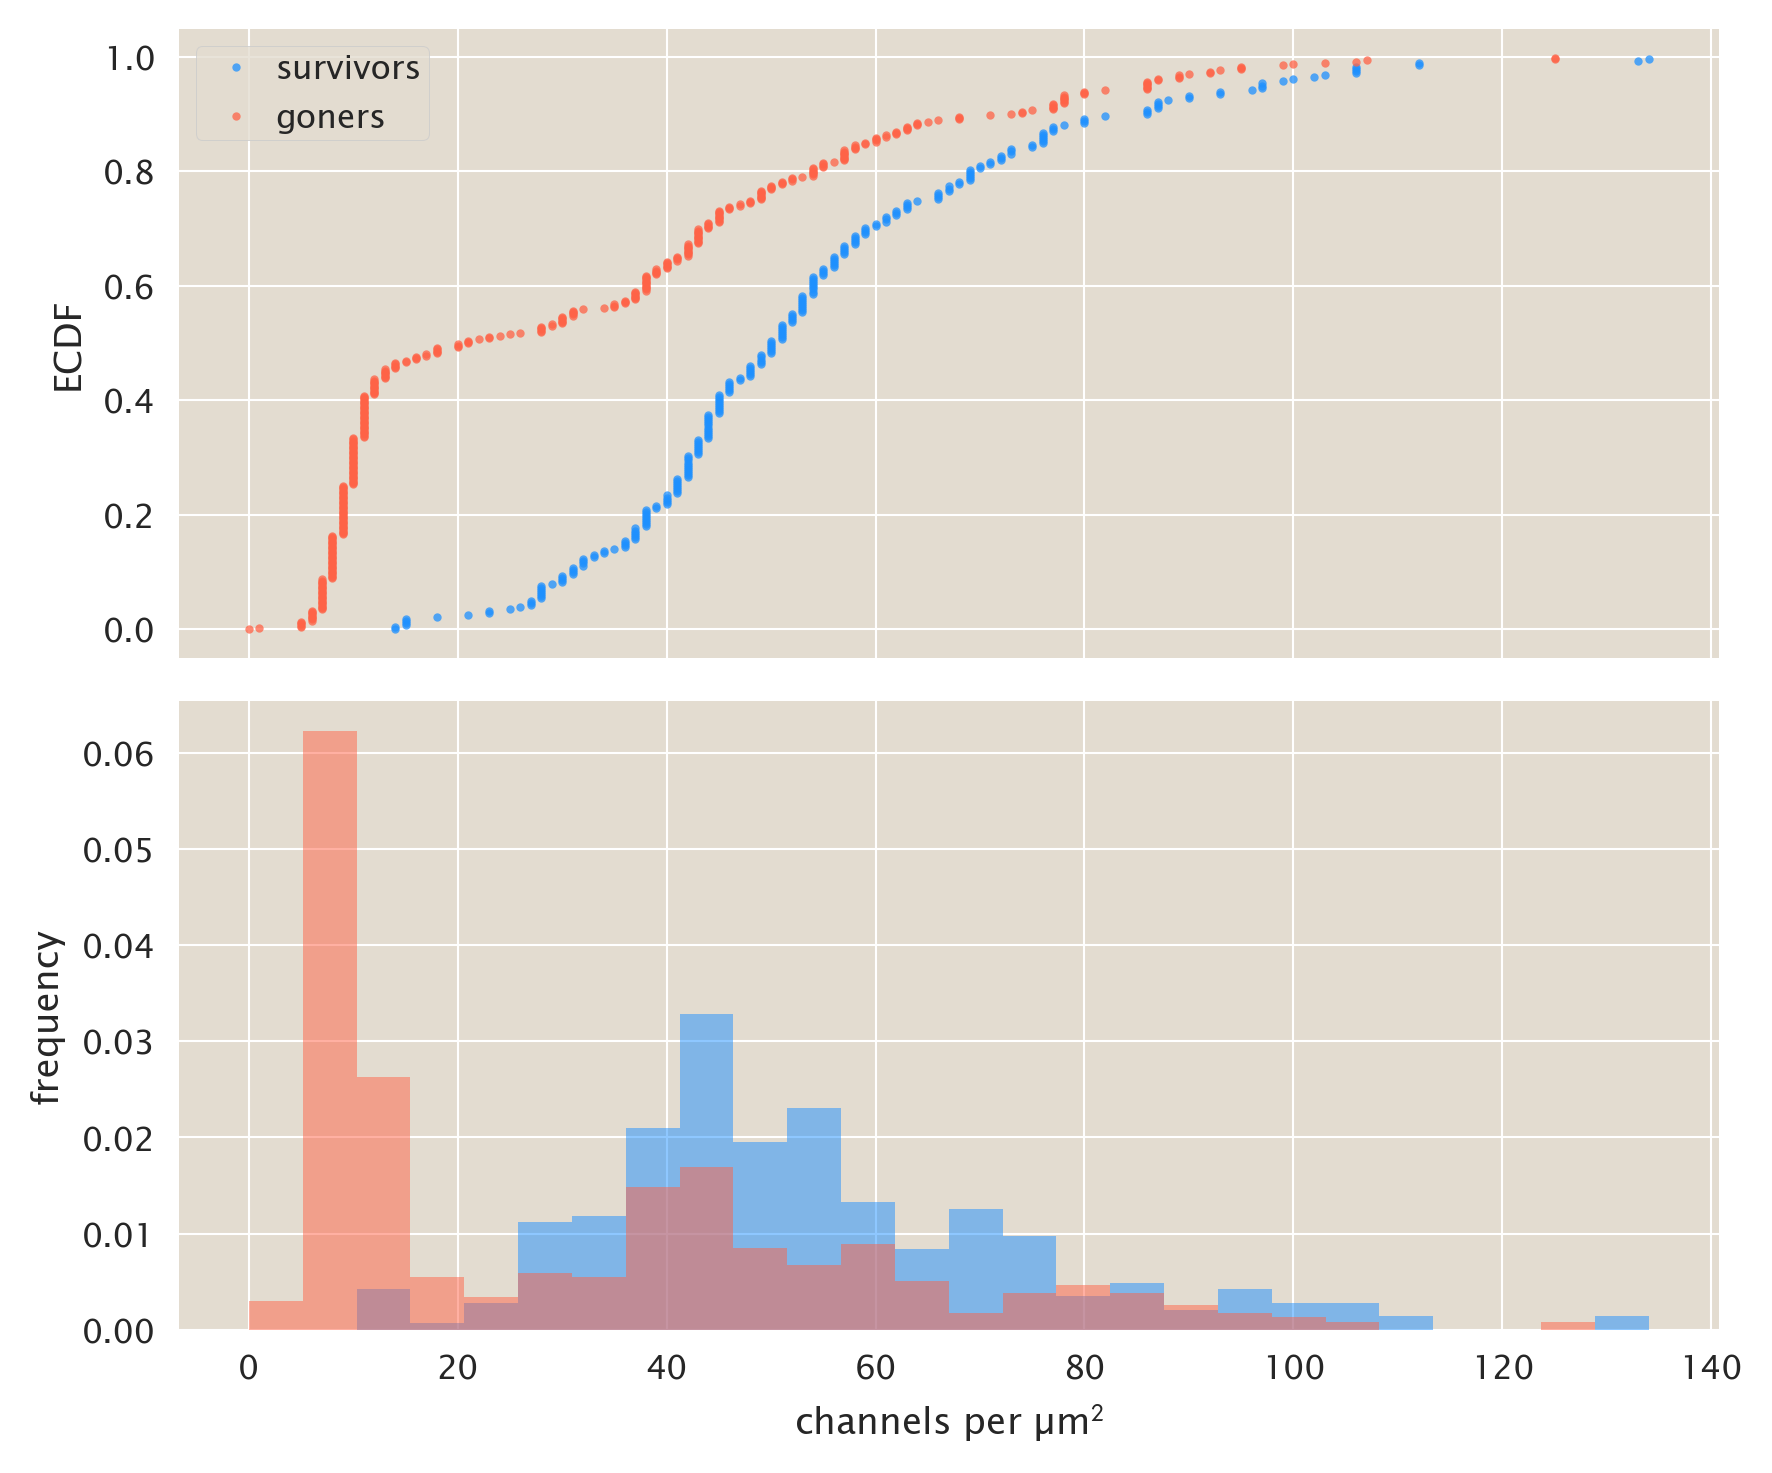

In [192]:
# Compute the ECDF
surv_x, surv_y = mscl.ecdf(shock_data[shock_data['survival']==True]['channel_density'])
death_x, death_y = mscl.ecdf(shock_data[shock_data['survival']==False]['channel_density'])

# Compute the histograms.
bins = np.linspace(shock_data['channel_density'].min(), shock_data['channel_density'].max(), 27)

fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('frequency')
_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5, normed=True)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5, normed=True)
_legend = ax[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../figs/analysis/survival_density_distribution.pdf', bbox_inches='tight',
           dpi=200)


In [173]:
# Rewrite the binning scheme. 

# 1. Define shock rate.
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'

# 2. Sort the data by channel density.
z = shock_data[shock_data['shock_group'] == 'fast']
sorted_data = z.sort_values(by='channel_density')

# 3. Define the bins from 0 to the max + desired binning
channel_bin = 10
max_density = shock_data['channel_density'].max() + channel_bin
bins = np.arange(0, max_density, channel_bin)

# 4. Set the temporary bin number to 0.
sorted_data['bin_number'] = 0

# 5. Count the number of cells in each bin. 
for i in range(1, len(bins) - 1):
    # Assign bin numbers based on channel density
    inds = (sorted_data['channel_density'] >= bins[i-1]) & (sorted_data['channel_density'] < bins[i+1])
    sorted_data.loc[inds,  'bin_number'] = i

# 6. Identify which bins should be merged.
grouped = sorted_data.groupby('bin_number')['survival'].count()
min_cells = 20 

# Find those with less than the minimum cell number.
bin_counts = grouped.to_dict()
low_bins = grouped[grouped < min_cells].to_dict()

# identifiy the eges of sequential bins with low cell counts.
bin_nos = list(low_bins.keys()) 

# Find the indices at which sequentiality is broken.
sequential = np.where(np.diff(bin_nos) > 1)[0]

# Separate the pairs.
if (len(sequential) == 0) * (len(bin_nos) != 0):
    paired = [bin_nos]    
else: 
    # Need to do fancy indexing here such that it returns even single bins.
    paired = [bin_nos[:sequential[0] + 1]]
    _paired = ([bin_nos[sequential[j-1] + 1:sequential[j] + 1] for j in range(1, len(sequential))])
    for _p in _paired:
        paired.append(_p)   
    paired.append(bin_nos[sequential[-1] + 1:])

# Determine if each pair can meet the minimum number of cells. 
change_bins = {}
for i, pair in enumerate(paired):
    if len(pair) > 1:
        summed = np.sum([bin_counts[p] for p in pair])
        if summed >= min_cells:
            for z in pair:
                change_bins[z] = pair[0]
        else:
            for z in pair:
                change_bins[z] = pair[0] - 1
    else:
        # If there is only one item in the pair, determine which one to add it to.
        if pair[0] == 1:
            change_bins[pair[0]] = pair[0] + 1
        elif pair[0] == sorted_data['bin_number'].max():
            change_bins[pair[0]] = pair[0] - 1
        else:
            change_bins[pair[0]] = pair[0] - 1
change_bins

{3: 2, 8: 8, 9: 8, 10: 8, 11: 8}

In [537]:
# Include some information about the shock group.
shock_data.loc[:, 'shock_group'] = 'all'

# Bin the data in units of 10 channels per square micron.
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin)
binned_data.head()

,index,area,date,exposure_ms,flow_rate,intensity,mean_bg,rbs,survival,rescaled_intensity,channel_density,density_err,shock_group,bin_number
0,561,15.8976,20170714,100,0.018,166722.996899,164038.517434,sd4,False,2684.479465,0,0,all,0
1,543,4.7616,20170714,100,0.018,191719.027121,184315.509854,sd4,False,7403.517267,1,0,all,0
2,386,6.2720,20170316,100,1.000,232978.539598,209289.154034,sd6,False,23689.385564,5,1,all,0
3,324,8.4224,20170316,100,1.000,230911.462795,206927.521606,sd6,False,23983.941189,5,1,all,0
4,243,9.1904,20170316,100,1.000,231440.243311,207238.522105,sd6,False,24201.721206,5,1,all,0


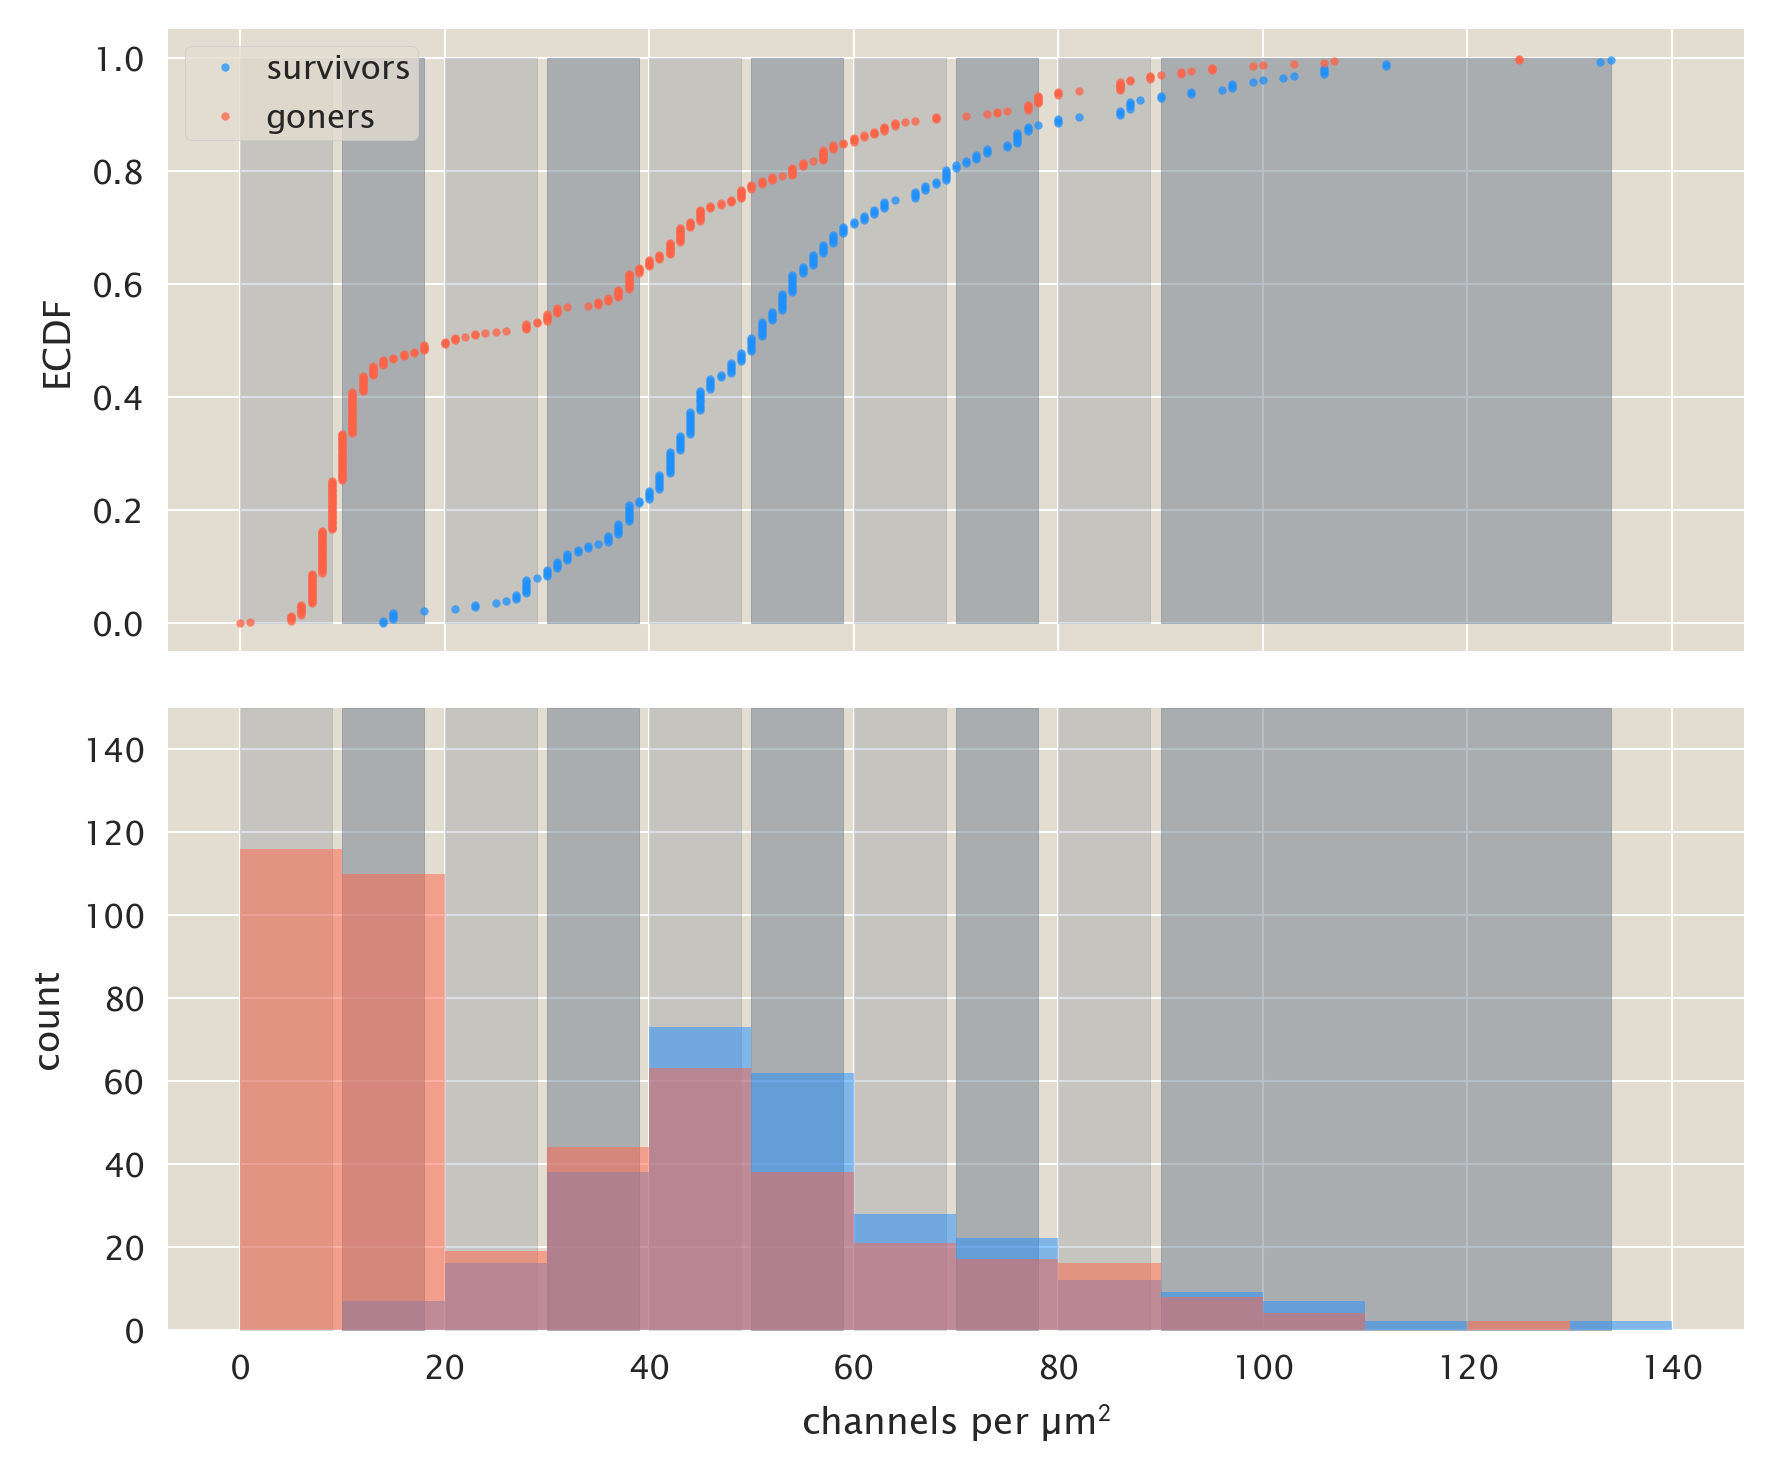

In [540]:
# Show the distribution plot as above, but with the bin numbers indicated. 
fig, ax = plt.subplots(2,1, figsize=(6, 5), sharex=True)
ax[1].set_xlabel('channels per µm$^2$')
ax[0].set_ylabel('ECDF')
ax[1].set_ylabel('count')
_ = ax[0].plot(surv_x, surv_y, 'o', markersize=2, color='dodgerblue', lw=2, alpha=0.75, label='survivors')
_ = ax[0].plot(death_x, death_y, 'o', markersize=2, color='tomato', lw=2, alpha=0.75, label='goners')
_ = ax[1].hist(shock_data[shock_data['survival']==True]['channel_density'], bins=bins,
                   color='dodgerblue', histtype='stepfilled', alpha=0.5)
_ = ax[1].hist(shock_data[shock_data['survival']==False]['channel_density'], bins=bins,
                   histtype='stepfilled', color='tomato', alpha=0.5)

# Shade the bins. 
binned_data.sort_values(by='channel_density', inplace=True)
grouped = binned_data.groupby('bin_number')
bins = np.arange(0, shock_data['channel_density'].max() + channel_bin, channel_bin)
for g, d in grouped:
    if g%2 == 0: 
         alpha=0.25
    else:
        alpha = 0.5 
    for i, a in enumerate(ax):
        if i == 0:
            top = 1
        else: 
             top = 150
        y = np.linspace(0, top, 500)
        a.fill_betweenx(y, d['channel_density'].min(), d['channel_density'].max(), color='slategray', alpha=alpha)
_legend = ax[0].legend(loc='upper left')

ax[1].set_ylim([0, 150])
plt.tight_layout()
plt.savefig('../figs/analysis/survival_density_distribution_with_bins.pdf', bbox_inches='tight',
           dpi=200)



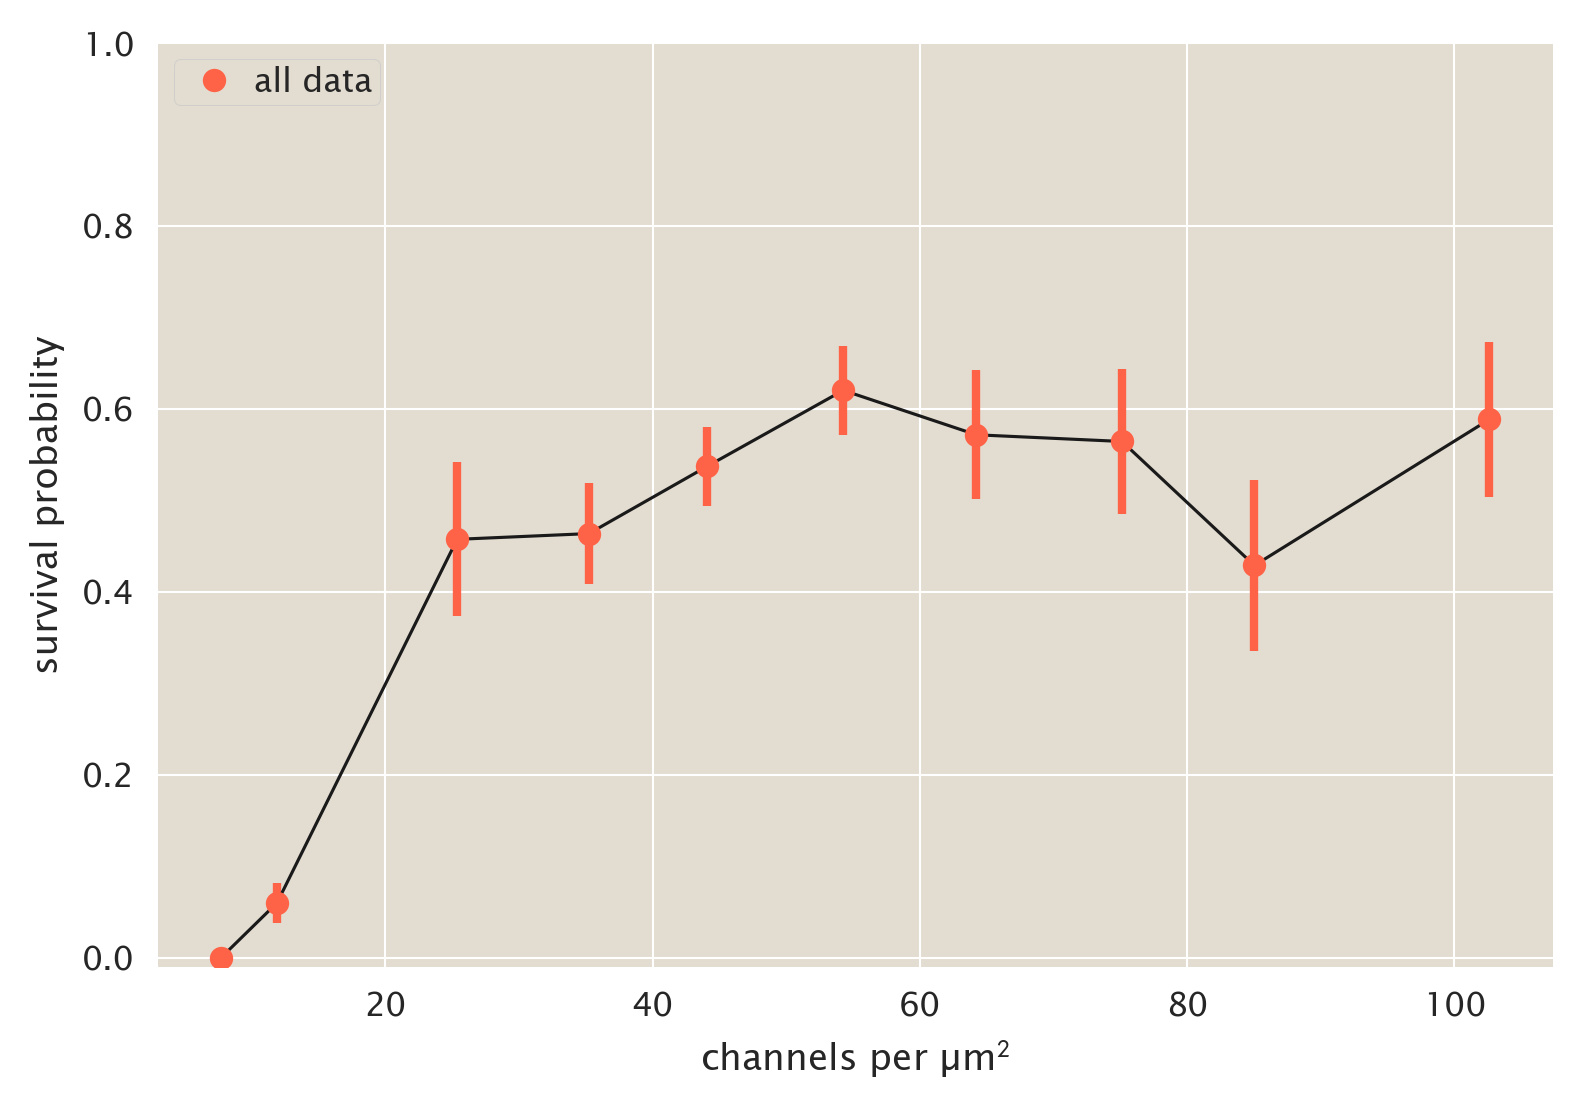

In [539]:
stats = binned_data.groupby('bin_number').apply(mscl.compute_survival_stats)
stats.sort_values(by='mean_chan', inplace=True)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')
_ = ax.plot(stats['mean_chan'], stats['prob'], lw=0.75, color='k', label='__nolegend__')
_ = ax.errorbar(stats['mean_chan'], stats['prob'], stats['err'], color='tomato',
           linestyle='none', label='__nolegend__')
_ = ax.plot(stats['mean_chan'], stats['prob'], 'o', markerfacecolor='tomato', 
           label='all data')

ax.set_ylim([-0.01, 1])

plt.legend(loc='upper left')
plt.savefig('../figs/analysis/all_data_nbins_10.pdf', bbox_inches='tight')     

In [245]:
# Bin the data by the shock group and show slow and fast. 
shock_data.loc[shock_data['flow_rate'] < 1.0, 'shock_group'] = 'slow'
shock_data.loc[shock_data['flow_rate'] >= 1.0, 'shock_group'] = 'fast'
channel_bin = 10 
binned_data = mscl.density_binning(shock_data, channel_bin=channel_bin,
                                  min_cells=10)
stats = mscl.compute_survival_stats(binned_data)


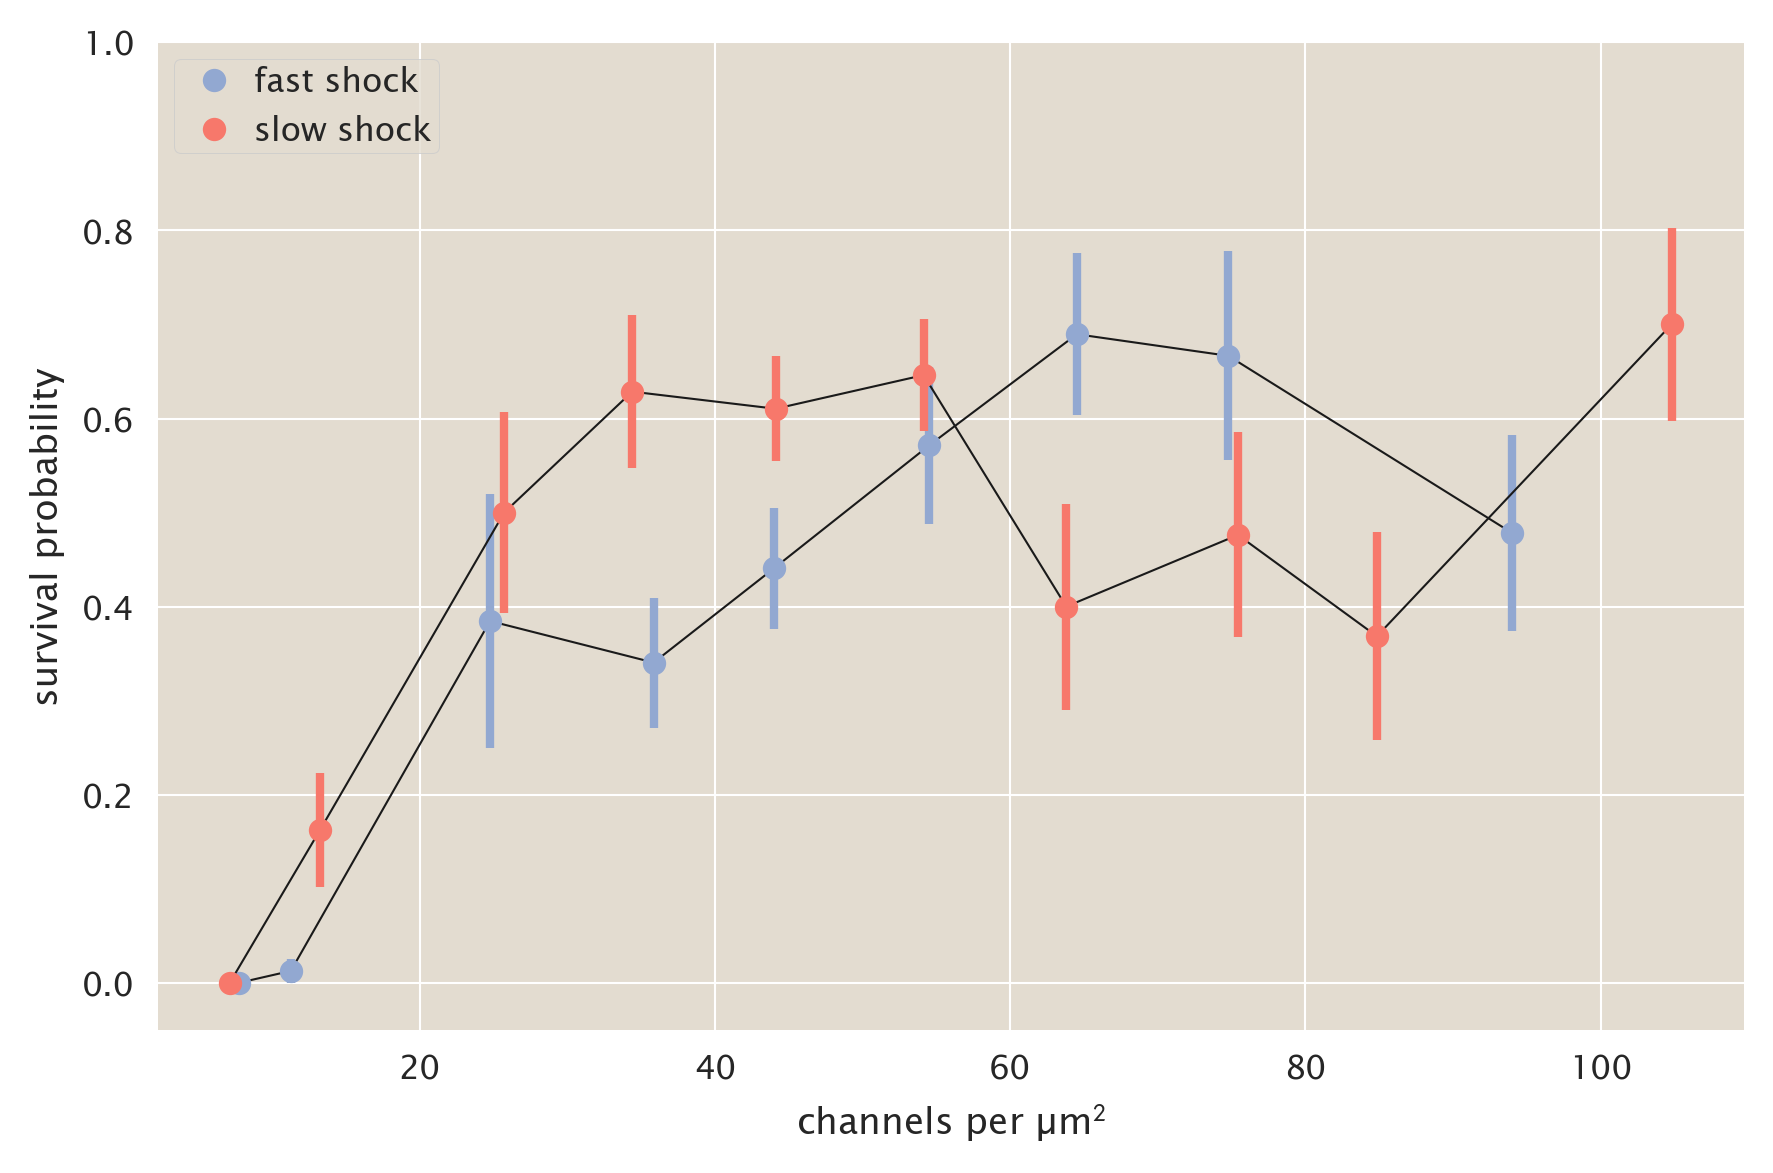

In [250]:
# Generate the figure of the shock rates. 
grouped = stats.groupby('shock_group')
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('survival probability')

colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
for g, d in grouped:
    _ = ax.errorbar(d['mean_chan'], d['prob'],  d['err'], color=colors[g],
                    label='__nolegend__', linestyle='none')
    _ = ax.plot(d['mean_chan'], d['prob'], 'k-', lw=0.5, label='__nolegend__')
    _ = ax.plot(d['mean_chan'], d['prob'],  'o', color=colors[g], label='{0} shock'.format(g))

_ = ax.legend(loc='upper left')
ax.set_ylim([-0.05, 1])
plt.tight_layout()
plt.savefig('../figs/analysis/shock_group_bin10_survival_curve.pdf', bbox_inches='tight')

## Logistic Regression 

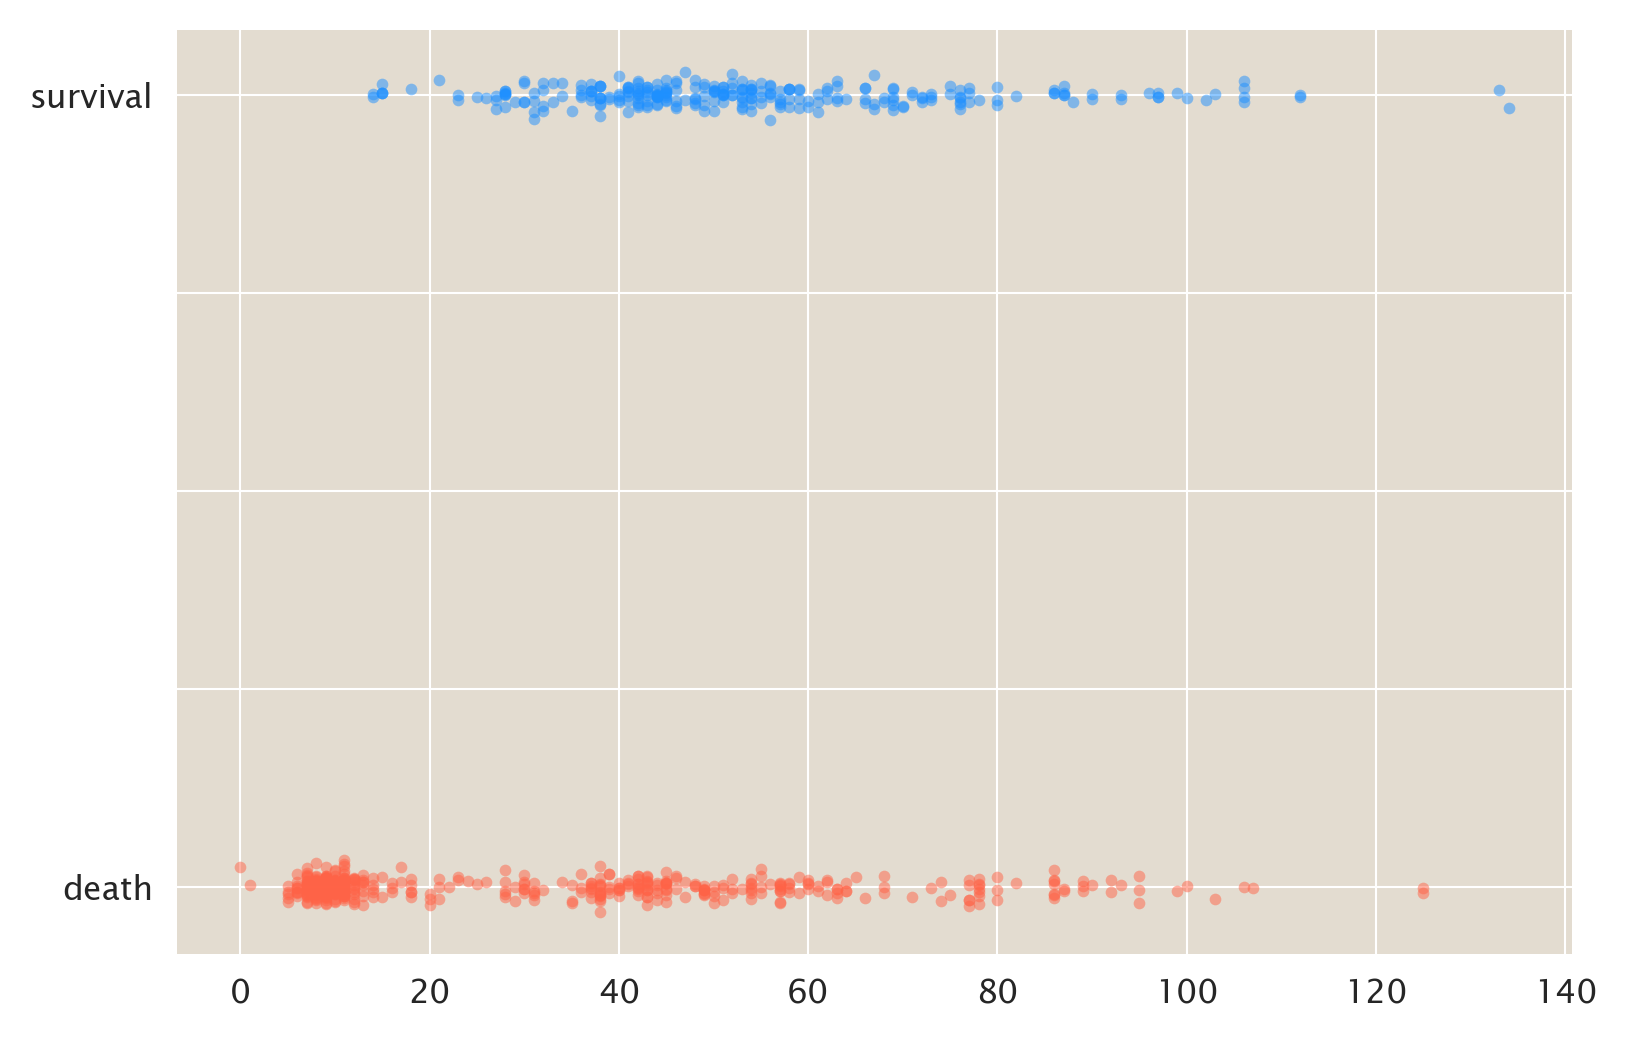

In [542]:
# Plot the rugplot of survival and death for everything.
grouped = shock_data.groupby('survival')
markers = {True: 'v', False: '^'}
colors = {True: 'dodgerblue', False:'tomato'}

# Set up the figure. 
fig, ax = plt.subplots(1,1, figsize=(6, 4))
for g, d in grouped:
    ax.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)), color=colors[g],
           marker='.', alpha=0.5, linestyle='None')
density = np.linspace(0, 150, 500)

# make a fake probability curve
theo = 1 / (1 + np.exp(-(-10 + 0.13*density)))
# ax.plot(density, theo, color='g')
ax.set_yticks([0, .25, .5, .75, 1])
ax.set_yticklabels(['death', '', '', '', 'survival'])
# ax.set_ylabel('probability of survival', x=-1, color='g')
plt.savefig('../figs/analysis/rugplot.pdf', bbox_inches='tight')

As I've discussed before, the model for survival is binomial,

$$
P(p_s \, \vert\, \rho) \propto \text{Binomial}(n_i, N_i\, \vert \, p_s, \rho)P(p_s).
$$

However, I don't have the luxury of having many measurements of survival with a single, well-defined channel density. Rather, I would like to know the probability of survival $p_s$ 

which, ignoring the flow rate fly in the ointment (for now), can be written more explicitly as
$$
P(p_s \, \vert\, \rho) \propto \text{Bernoulli}(y_i, p_s(\rho))
$$

In [351]:
model = pm.Model()
with model:
    beta_0 = pm.Normal('b_0', mu=0, sd=20, testval=-2)
    beta_1 = pm.Normal('b_1', mu=0, sd=20, testval=0)
    
    rho = shock_data['channel_density'].values
    mu = beta_0 + beta_1 * rho
    like = pm.Bernoulli('like', p=mscl.theano_logistic(mu), observed=shock_data['survival'].values.astype(int))
    
    # Sample the distribution.
    start = pm.find_MAP(model=model)
    step = pm.Metropolis()
    burn = pm.sample(draws=10000, start=start, step=step, njobs=None)
    step = pm.Metropolis()
    trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
    df = mscl.trace_to_df(trace,  model=model) 
    stats = mscl.compute_mcmc_statistics(df)

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 432.536158
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 13


100%|██████████| 50000/50000 [00:32<00:00, 1558.00it/s]


In [396]:
# Compute the credible region.
var = np.linspace(-1, 150, 500)
cred_region = np.zeros((2, len(var)))
for i, v in enumerate(var):
    mu = df['b_0'].values + df['b_1'].values * v
    prob = (1 + np.exp(-mu))**-1
    cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95)

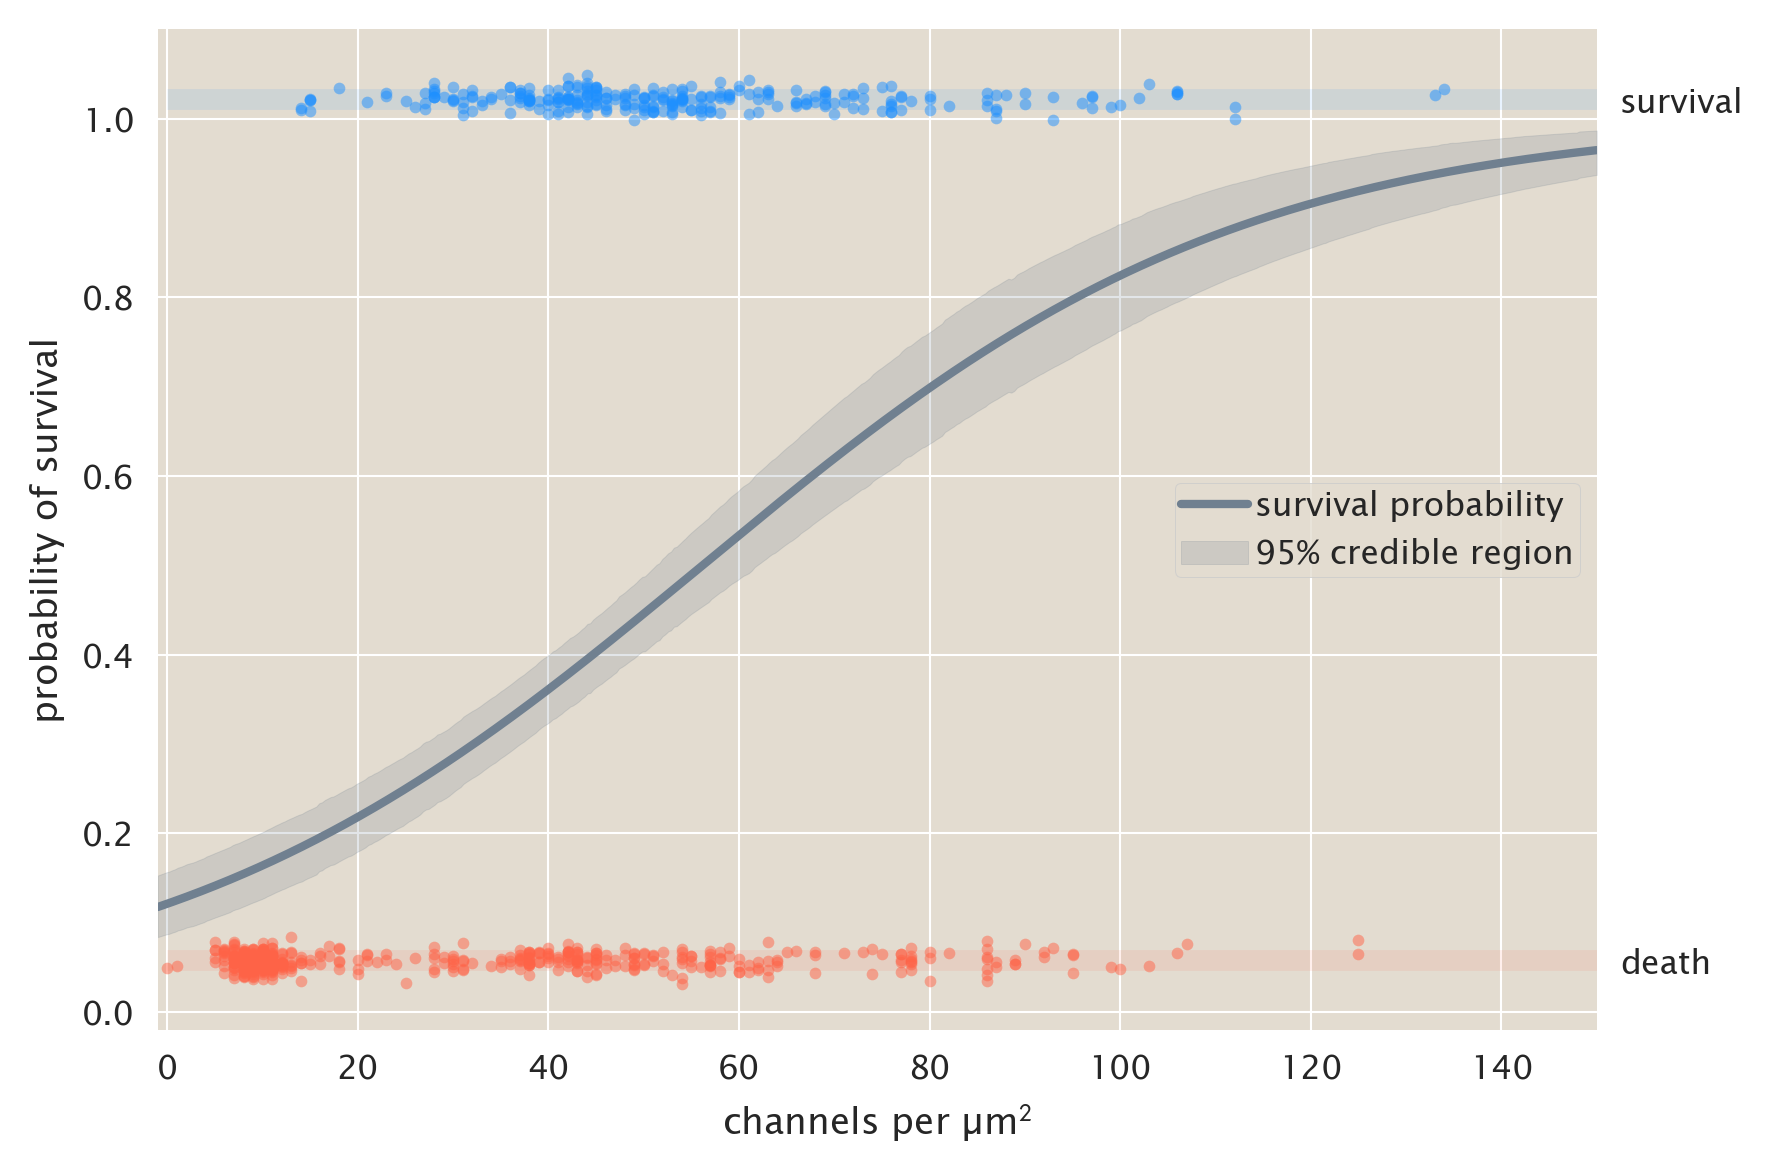

In [415]:
theo_mu = stats['b_0'][0] + stats['b_1'][0] *  var
prob = (1 + np.exp(-theo_mu))**-1
grouped = shock_data.groupby('survival')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax2 = ax.twinx()
ax.set_xlabel('channels per µm$^2$')
ax.set_ylabel('probability of survival')
ax2.set_yticks([0, 1])
ax2.hlines(0, 0, 150, color='tomato', alpha=0.1, lw=5)
ax2.hlines(1, 0, 150, color='dodgerblue', alpha=0.1, lw=5)
ax2.set_yticklabels(['death', 'survival'])
ax.set_xlim([-1, 150])
ax.set_ylim([-0.02, 1.1])
ax2.grid(False)

# Plot the prediction curve and the credible region.
_ = ax.plot(var, prob, color='slategray', label='survival probability')
_ = ax.fill_between(var, cred_region[0, :], cred_region[1, :], color='slategray',
               alpha=0.2, label='95% credible region')

# Plot the rug of survival.
for g, d in grouped:
    ax2.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)), color=colors[g],
           marker='.', alpha=0.5, linestyle='None') 
ax.legend(loc='center right')
plt.tight_layout()
plt.savefig('../figs/analysis/logistic_regression_all_data.pdf', bbox_inches='tight')

In [ ]:
rho = np.linspace(0, 200, 500)
cred_region = np.zeros((2, len(rho)))
for i, val in enumerate(rho):
    mu =  df['b_0'].values + df['b_1'].values * rho[i]
    prob = (1 + np.exp(-mu))**-1
    cred_region[:, i] = compute_hpd(prob, mass_frac=0.95) 

In [384]:
np.shape(cred_region)

(2, 50000)

In [ ]:
a = [1, 2, 3]
b = [[1, 1, 1], [2, 2, 2], [3, 3, 3]]


In [452]:
def multinomial_linear(coeff, variables):
    """
    Computes a multinomial linear relation of the form. 
    
          y = β_0 + β_1*x1 + β_2 * x2 ... + β_n * xn
    
    Parameters
    ----------
    coeff: list
        Array of coefficients for the linear model. The first entry
        is the intercept.
    variables: list of 1d-arrays
        List of x-variable corresponding to coefficients. This
         must be length 1 longer than coeff.
         
    Returns
    -------
    y: nd-array
        Result of the linear model. 
    """
    y = coeff[0] + coeff[1:] * variables[:]
    return y  

def mcmc_logistic_regression(obs, variables):
    model = pm.Model()
    with model:
        # Define the priors on the coefficients.
        beta_0 = pm.Normal('b_0', mu=0, sd=20) 
        beta_1 = pm.Normal('b_1', mu=0, sd=20) 
        
        # Compute the logit and probability.
        logit = beta_0 + beta_1 * variables
        prob = mscl.theano_logistic(logit)
       
        # Compute the likelihood.
        like = pm.Bernoulli('like', p=mscl.theano_logistic(logit), observed=obs)

        # Sample the distribution.
        start = pm.find_MAP()
        
        # Sample using metropolis
        step = pm.Metropolis()
        burn = pm.sample(draws=10000, start=start, step=step, njobs=None, progressbar=False)
        step = pm.Metropolis()
        trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
        
    # Convert results to a dataframe.
    df = mscl.trace_to_df(trace,  model=model) 
    stats = mscl.compute_mcmc_statistics(df)
    return [df, stats]


In [464]:
# Group by shock_rate
grouped = shock_data.groupby(['shock_group'])
var = np.linspace(0, 150, 500)

dfs, cred_regions, modes, group = [], [], [], []
for g, d in grouped:
    group.append(g)
    # Define the data
    obs = d['survival'].values.astype(int)
    variables = d['channel_density'].values
    
    # Sample the posterior
    df, stats = mcmc_logistic_regression(obs, variables)
    dfs.append(df)
    
    # Compute the statistics and credible regions
    modes.append([stats['b_0'][0], stats['b_1'][0]])    
    cred_region = np.zeros((2, len(var)))
    for i, v in enumerate(var):
        logit = df['b_0'] + v * df['b_1']
        prob = (1 + np.exp(-logit))**-1
        cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95) 
    cred_regions.append(cred_region) 

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 189.399818
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 50000/50000 [00:27<00:00, 1846.58it/s]


Optimization terminated successfully.
         Current function value: 230.752367
         Iterations: 7
         Function evaluations: 17
         Gradient evaluations: 11


100%|██████████| 50000/50000 [00:33<00:00, 1472.05it/s]


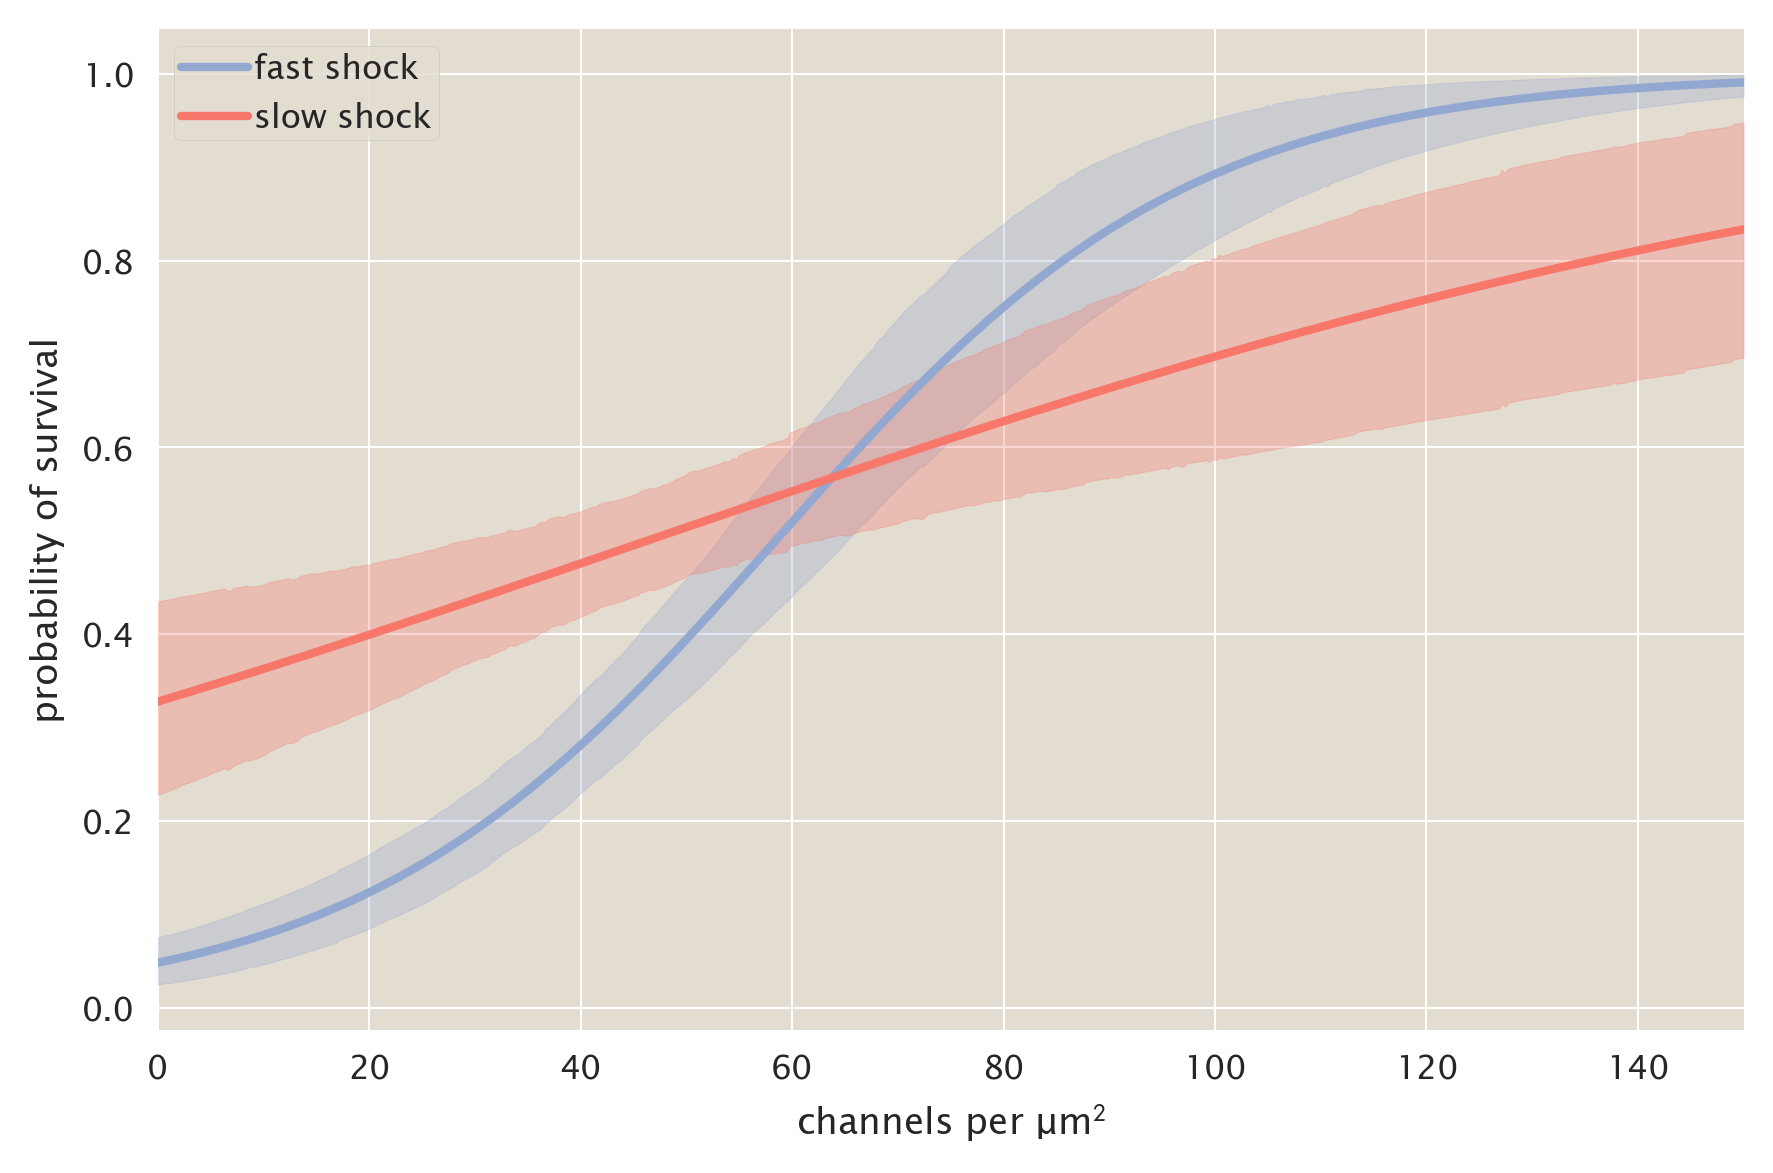

In [510]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_xlabel('channels per μm$^2$')
ax.set_ylabel('probability of survival')
colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
for i, m in enumerate(modes):
    logit = m[0] + var * m[1]
    prob = (1 + np.exp(-logit))**-1
    ax.plot(var, prob, label='{0} shock'.format(group[i]),color=colors[group[i]])
    ax.fill_between(var, cred_regions[i][0, :], cred_regions[i][1, :], color=colors[group[i]], 
                   alpha=0.3, label='__nolegend__', interpolate=True)
ax.set_xlim([0, 150])
plt.legend()
plt.tight_layout()
plt.savefig('../figs/analysis/logistic_regression_shock_group.pdf', bbox_inches='tight')

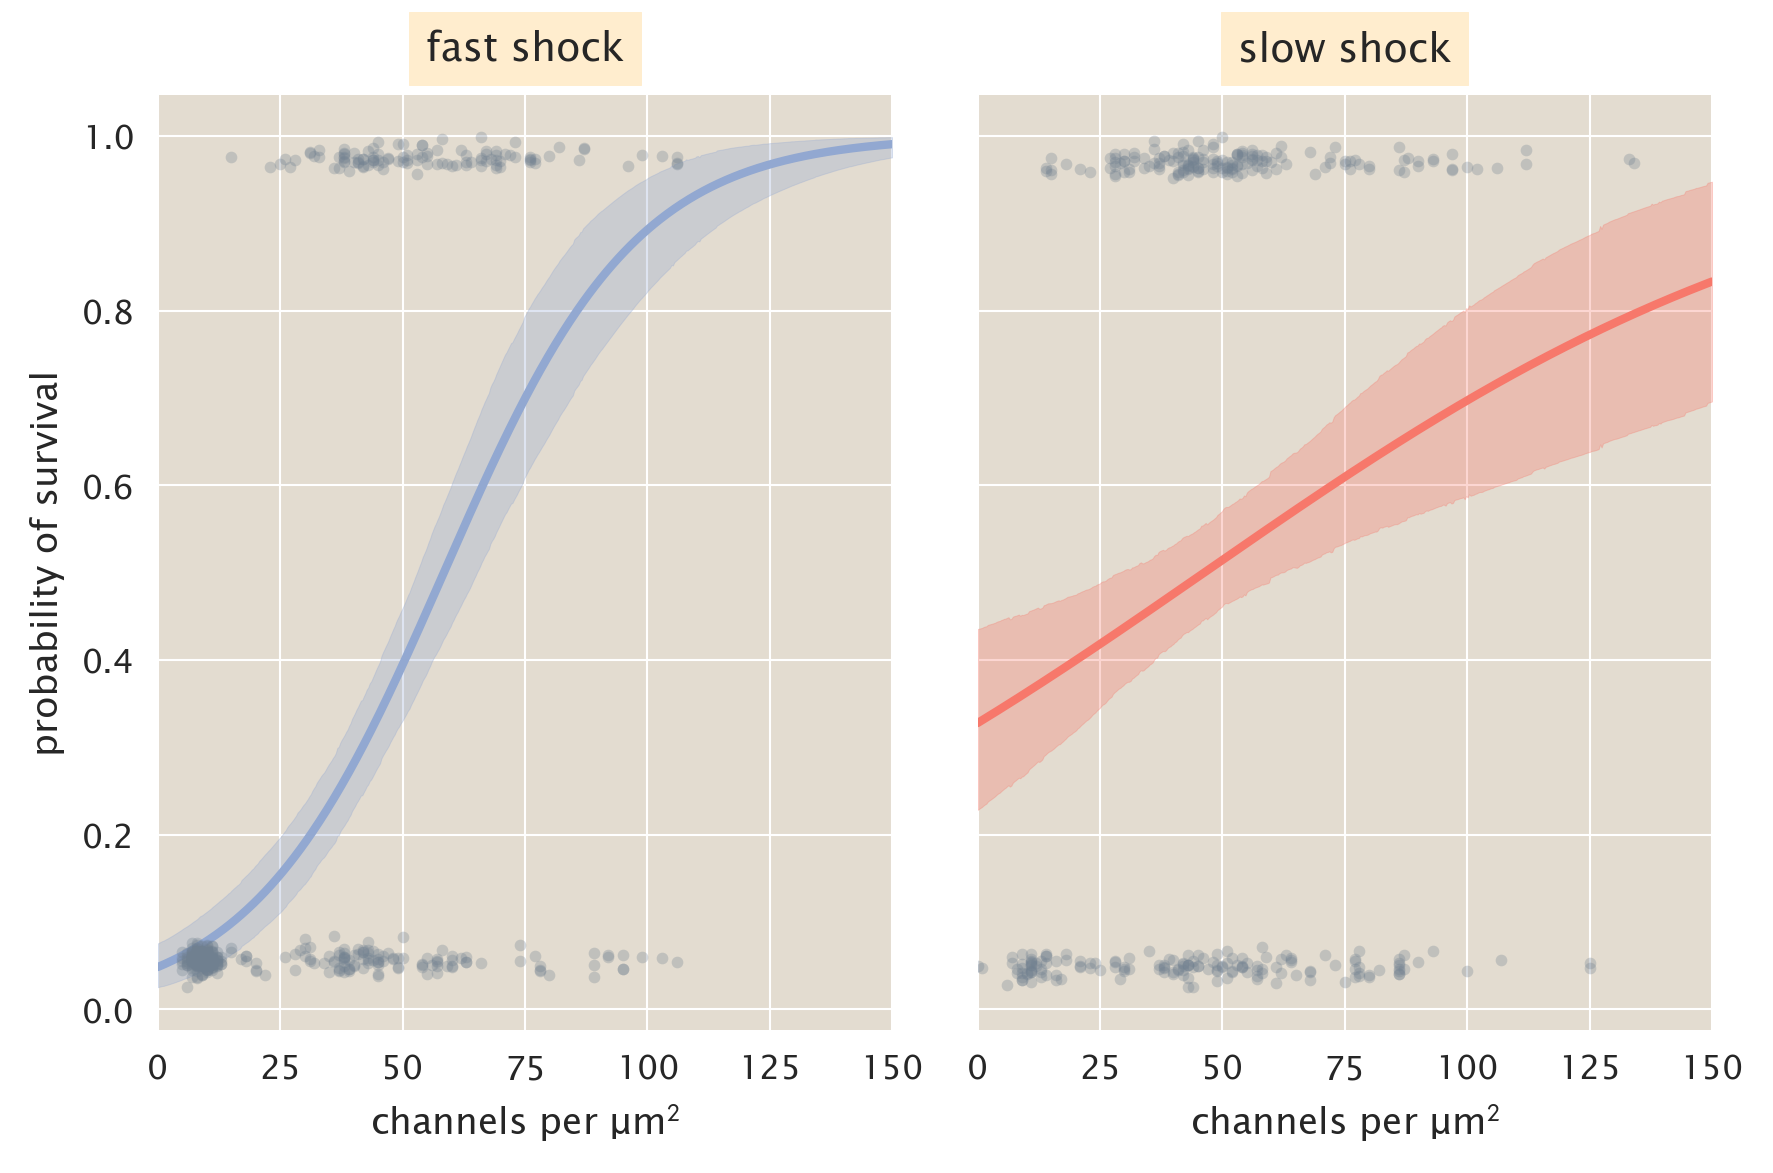

In [520]:
fig, ax = plt.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)

ax[0].set_ylabel('probability of survival')   
colors = {'fast': '#92a8d1', 'slow': '#f7786b'}
axes = {'fast': ax[0], 'slow':ax[1]}
for i, m in enumerate(modes):
    logit = m[0] + var * m[1]
    prob = (1 + np.exp(-logit))**-1
    axes[group[i]].plot(var, prob, label='{0} shock'.format(group[i]),color=colors[group[i]])
    axes[group[i]].fill_between(var, cred_regions[i][0, :], cred_regions[i][1, :], color=colors[group[i]], 
                   alpha=0.3, label='__nolegend__', interpolate=True)

for g, d in grouped:
    ax2 = axes[g].twinx() 
    ax2.plot(d['channel_density'], d['survival'].astype(int) + np.random.normal(scale=0.01, size=len(d)), '.',
             color='slategray', alpha=0.3)
    ax2.grid(False)
    ax2.set_yticks([])
 
ax[0].set_title('fast shock', backgroundcolor='#FFEDCE', y=1.01) 
ax[1].set_title('slow shock', backgroundcolor='#FFEDCE', y=1.01)

for a in ax:
    a.set_xlabel('channels per μm$^2$')

    a.set_xlim([0, 150])
plt.tight_layout()
plt.savefig('../figs/analysis/logistic_regression_shock_group_rugplot.pdf', bbox_inches='tight')

In [523]:
# Do the binary prediction. 
model = pm.Model()
with model:
    # Define the priors on the coefficients.
    beta_0 = pm.Normal('b_0', mu=0, sd=20) 
    beta_1 = pm.Normal('b_1', mu=0, sd=20) 

    
    # Define the dependent variables
    rate = shock_data['flow_rate'].values
    obs = shock_data['survival'].astype(int)
   
    # Compute the logit and probability. 
    logit = beta_0 + beta_1 * rate
    prob = mscl.theano_logistic(logit)
     
    # Compute the likelihood.
    like = pm.Bernoulli('like', p=mscl.theano_logistic(logit), observed=obs)

    # Sample the distribution.
    start = pm.find_MAP()
      
    # Sample using metropolis
    step = pm.Metropolis()
    burn = pm.sample(draws=10000, step=step, njobs=None, progressbar=False)
    step = pm.Metropolis()
    trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
       
# Convert results to a dataframe.
df = mscl.trace_to_df(trace,  model=model) 
stats = mscl.compute_mcmc_statistics(df) 

cred_region = np.zeros((2, len(var)))
var = np.linspace(0, 2.5, 500)
for i, v in enumerate(var):
    logit = df['b_0'] + v * df['b_1']
    prob = (1 + np.exp(-logit))**-1
    cred_region[:, i] = mscl.hpd(prob, mass_frac=0.95) 



/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 495.531446
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


100%|██████████| 50000/50000 [00:29<00:00, 1707.08it/s]


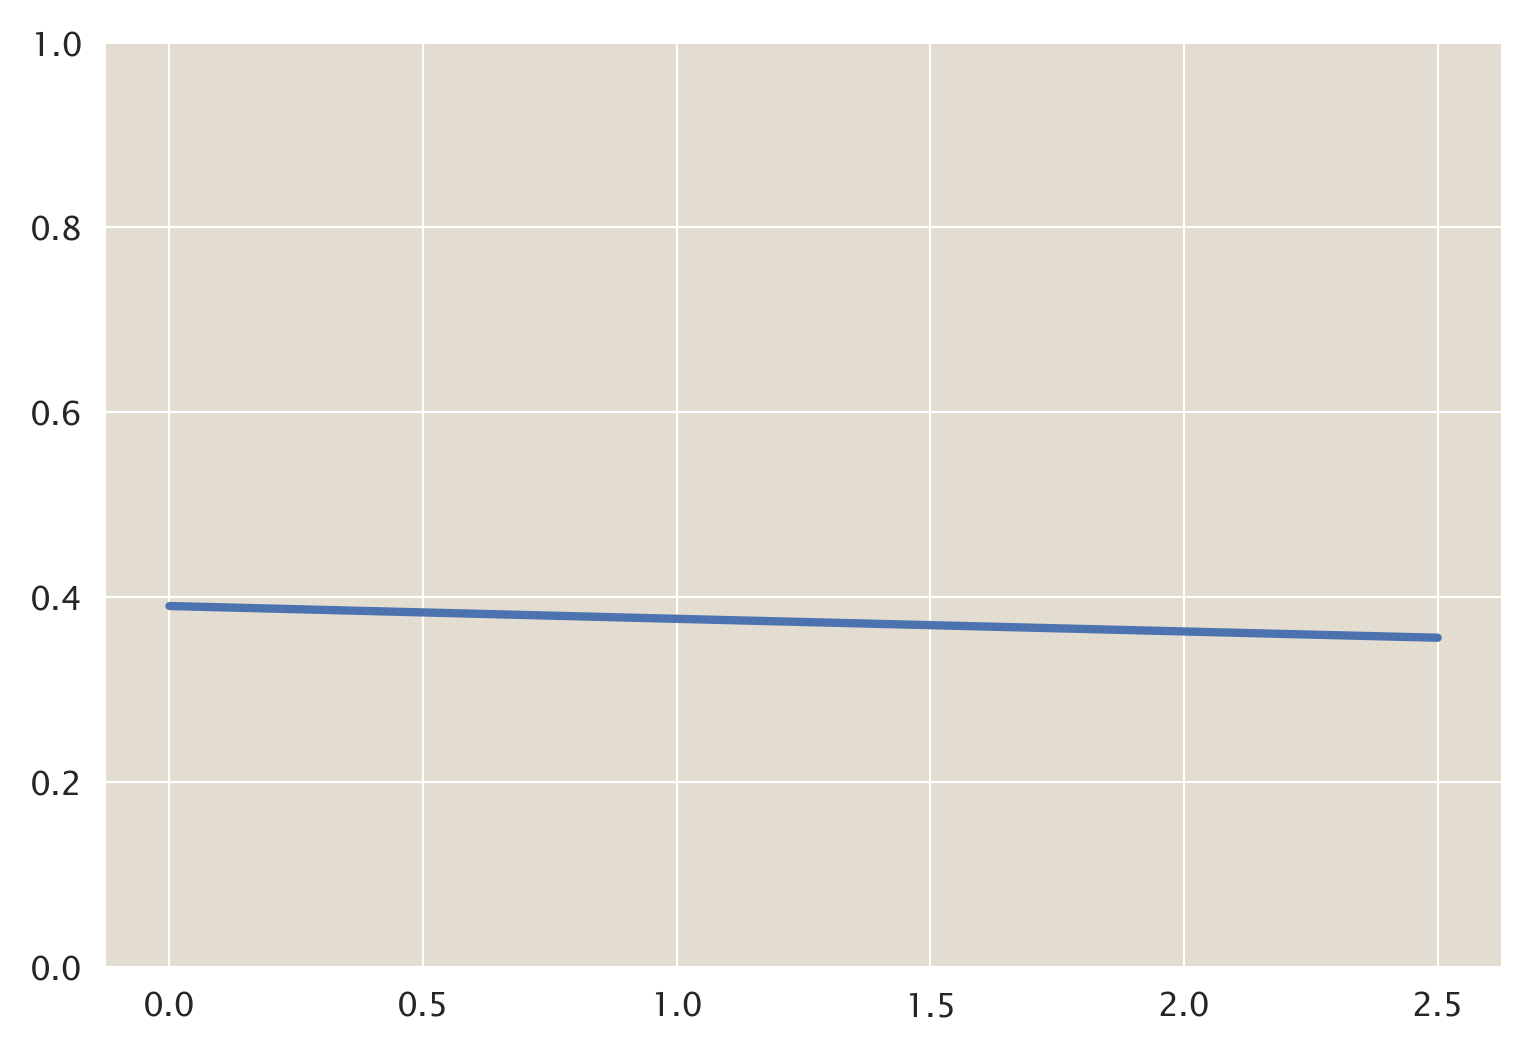

In [525]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
logit = stats['b_0'][0] + stats['b_1'][0] * var
prob = (1 + np.exp(-logit))**-1
ax.set_ylim([0, 1])
ax.plot(var, prob)

In [532]:
# Do the binary prediction. 
model = pm.Model()
with model:
    # Define the priors on the coefficients.
    beta_0 = pm.Normal('b_0', mu=0, sd=20) 
    beta_1 = pm.Normal('b_1', mu=0, sd=20) 
    beta_2 = pm.Normal('b_2', mu=0, sd=20)
    
    # Define the dependent variables
    density = shock_data['channel_density'].values
    rate = shock_data['flow_rate'].values
    obs = shock_data['survival'].astype(int)
   
    # Compute the logit and probability. 
    logit = beta_0 + beta_1 * density + (beta_2  + beta_1)* rate
    prob = mscl.theano_logistic(logit)
     
    # Compute the likelihood.
    like = pm.Bernoulli('like', p=mscl.theano_logistic(logit), observed=obs)

    # Sample the distribution.
    start = pm.find_MAP()
      
    # Sample using metropolis
    step = pm.Metropolis()
    burn = pm.sample(draws=10000, start=start, step=step, njobs=None, progressbar=False)
    step = pm.Metropolis()
    trace = pm.sample(draws=50000, start=burn[-1], step=step, njobs=None) 
       
# Convert results to a dataframe.
df = mscl.trace_to_df(trace,  model=model) 
stats = mscl.compute_mcmc_statistics(df) 

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 435.809980
         Iterations: 12
         Function evaluations: 28
         Gradient evaluations: 19


100%|██████████| 50000/50000 [00:58<00:00, 851.21it/s]


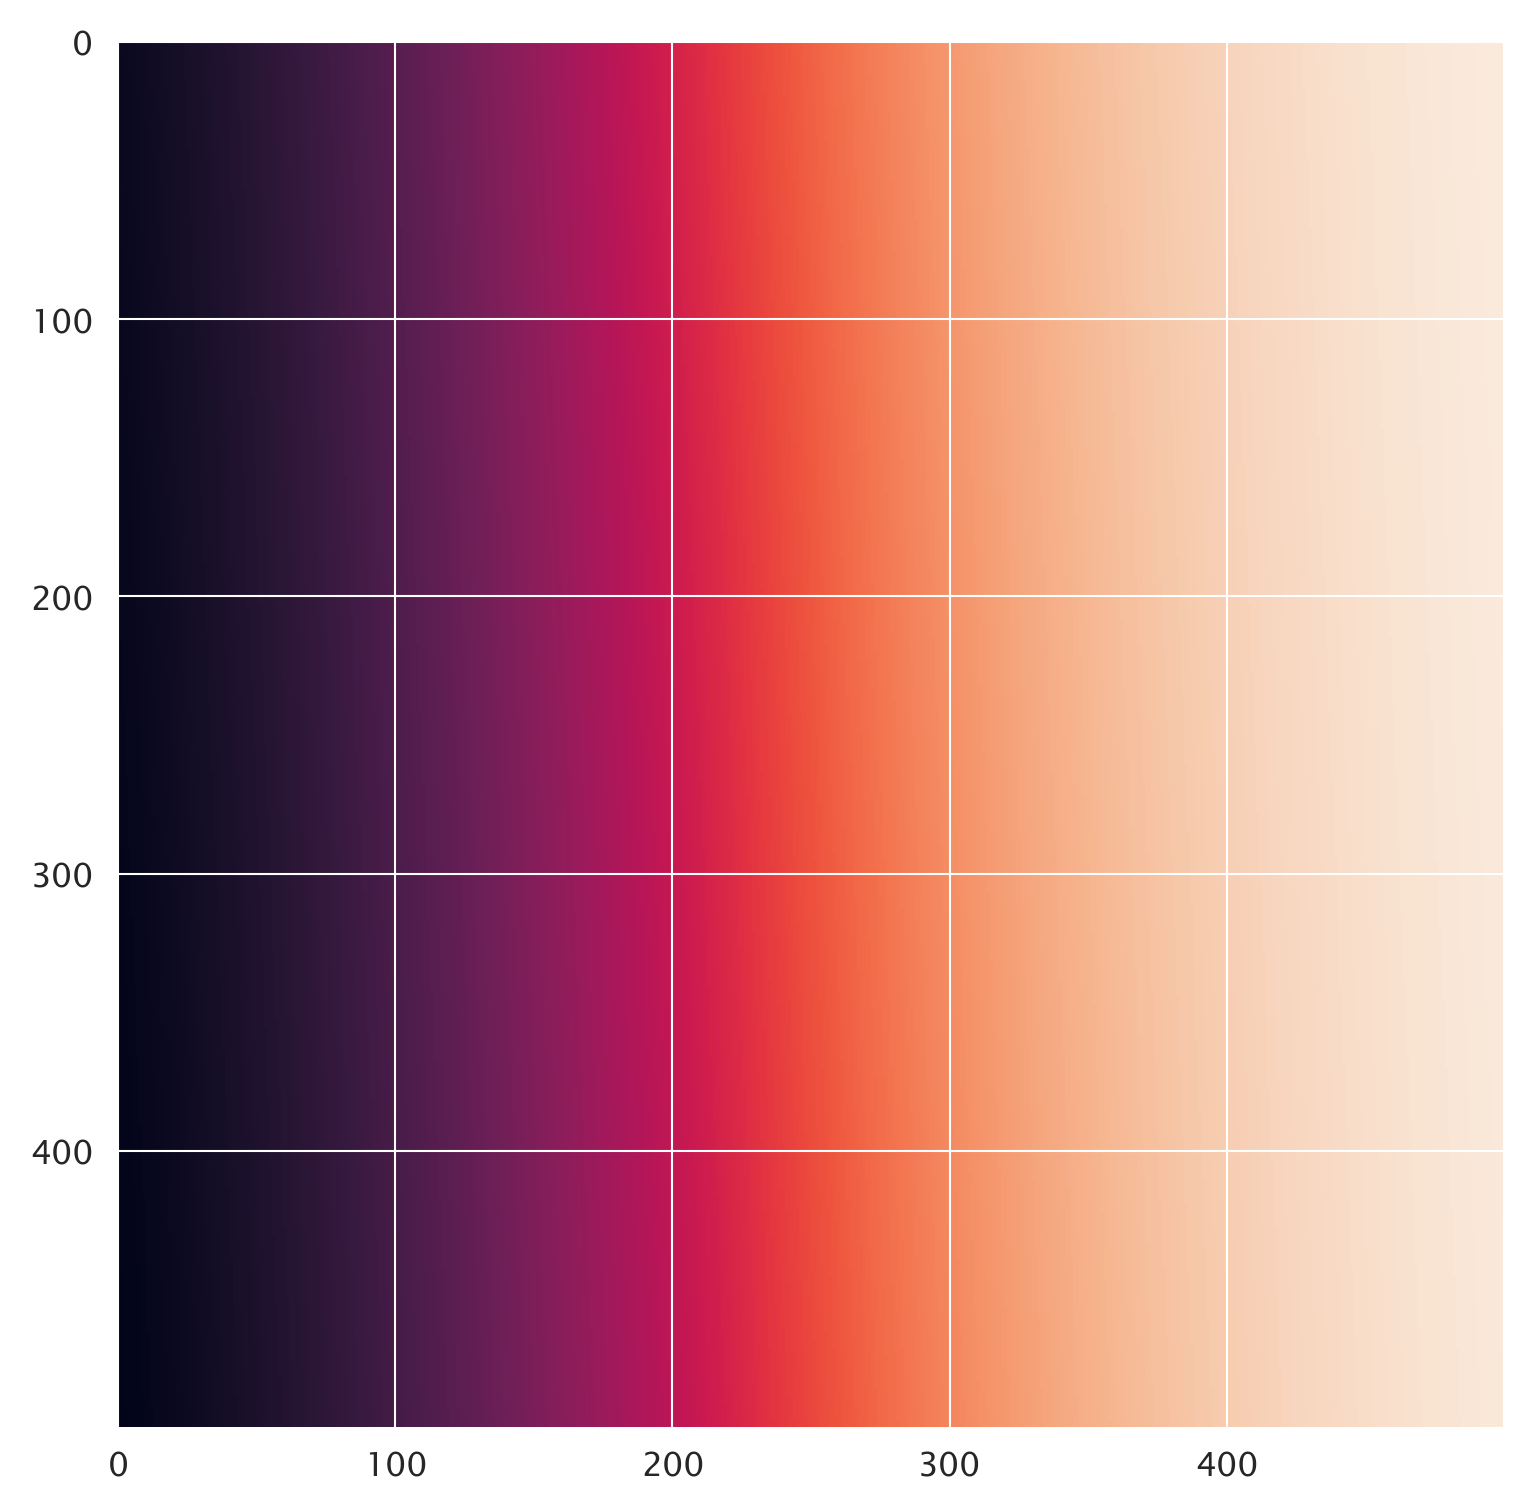

In [534]:
# Set up the grid matrix. 
flow_rates = np.linspace(0, 2, 500)
density = np.linspace(0, 150, 500)
X, Y = np.meshgrid(density, flow_rates)

logit = stats['b_0'][0] + stats['b_1'][0] * X + (stats['b_2'][0] + stats['b_1'][0]) * Y
prob = (1 + np.exp(-logit))**-1
fig, ax = plt.subplots(1, 1)
ax.imshow(prob, interpolation='none')
